## Set up Dataset

In [25]:
import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf

import pickle
import os

config = cf.read_json("../experiments/triplet_ge_first/config.json")
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])
torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

if "precomputed_val" in config['dataset']:
    val_dataset = pickle.load(open(config['dataset']["precomputed_val"], "rb"))
elif "save_val" in config['dataset']:
    val_dataset = pickle.load(open(config['dataset']["save_val"], "rb"))
else:
    val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="val")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

### Load Model

In [26]:
import torch
import torch.nn as nn
import sys

model = torch.load("../experiments/triplet_ge_first/checkpoint_triplet_ge_first_95_val_mrr=0.08731826.pth")

In [31]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()

        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()

    return gex_embeddings, chem_embeddings, np.array(smiles_gex_labels), np.array(smiles_chem_labels)

In [40]:
gex_embeddings, chem_embeddings, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_embeddings.shape, chem_embeddings.shape, len(smiles_gex_labels), len(smiles_chem_labels)


((2642, 128), (2248, 128), 2642, 2248)

In [75]:
import pandas as pd
gex_embeddings_pd = pd.DataFrame(data=gex_embeddings, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_pd = pd.DataFrame(data=chem_embeddings, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()
assert(all(gex_embeddings_pd.index.values == chem_embeddings_pd.index.values))

In [180]:
from scipy.spatial.distance import cdist
gex_chem_embed_dist = cdist(gex_embeddings_pd, chem_embeddings_pd,  metric='correlation')

gex_chem_dists = gex_chem_embed_dist[np.triu_indices(2248, k=1)]

gex_chem_embed_dist.shape, len(gex_chem_dists)

((2248, 2248), 2525628)

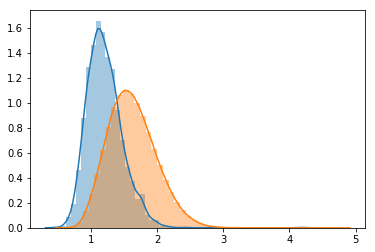

In [101]:
import seaborn as sns
sns.distplot(gex_chem_embed_dist.diagonal())
sns.distplot(gex_chem_embed_dist[np.triu_indices(2248, k=1)])

## Tanimoto similarity

In [104]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]

0.4357066950053135

In [173]:
inds = np.triu_indices(2248, k=1)
tanimoto_dists = [1 - DataStructs.FingerprintSimilarity(fps[inds[0][i]],
                                   fps[inds[1][i]])
 for i in range( len(inds[0]) )
]

## GE similarity 

In [174]:
average_ges = val_dataset.l1000_perts.groupby('canonical_smiles').mean().rename_axis(index=['smiles'])
ge_dists = cdist(average_ges,average_ges, "correlation")[np.triu_indices(2248,k=1)]

In [175]:
len(tanimoto_dists),len(gex_chem_dists),len(ge_dists)

(2525628, 2525628, 2525628)

## Correlations of Distances

In [184]:
(np.corrcoef(tanimoto_dists, ge_dists)[0,1],
 np.corrcoef(tanimoto_dists, gex_chem_dists)[0,1],
 np.corrcoef(gex_chem_dists, ge_dists)[0,1])

(-0.004268703627652702, 0.0018247136639383485, 0.17646798735978958)

In [182]:
all_sims = 1 - pd.DataFrame({'Tanimoto':tanimoto_dists,
                              'GE':ge_dists,
                              'Model':gex_chem_dists
                             })
all_sims.head(20)

,Tanimoto,GE,Model
0,0.435707,0.776789,0.698211
1,0.321149,-0.310253,0.426691
2,0.369099,-0.356795,0.339690
3,0.476457,0.798023,0.717512
4,0.431456,-0.150452,0.575512
5,0.448537,-0.137618,0.243200
6,0.415054,0.010475,0.433288
7,0.302657,0.099169,0.346650
8,0.331847,-0.002384,0.324262
9,0.330940,-0.039943,0.392887


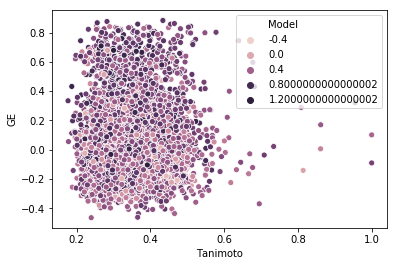

In [192]:
sns.scatterplot(x="Tanimoto", y="GE",
                hue='Model',
                data = all_sims.sample(5000))

## Do CCA 

In [196]:
#gex_embeddings, chem_embeddings, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
#gex_embeddings.shape, chem_embeddings.shape, len(smiles_gex_labels), len(smiles_chem_labels)

gex_embeddings_train, chem_embeddings_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_embeddings_train.shape, chem_embeddings_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((29548, 128), (6318, 128), 29548, 6318)

In [198]:
gex_embeddings_train_pd = pd.DataFrame(data=gex_embeddings_train, index = smiles_gex_labels_train).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_train_pd = pd.DataFrame(data=chem_embeddings_train, index = smiles_chem_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_embeddings_train_pd.shape, chem_embeddings_train_pd.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)


((6318, 128), (6318, 128), 29548, 6318)

In [227]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=50)
cca.fit(gex_embeddings_train_pd, chem_embeddings_train_pd)

CCA(copy=True, max_iter=500, n_components=50, scale=True, tol=1e-06)

In [228]:
cca_gex_val, cca_chem_val = cca.transform(gex_embeddings, chem_embeddings)
cca_gex_val.shape, cca_chem_val.shape

((2642, 50), (2248, 50))

In [229]:
gex_chem_cca_dist = cdist(cca_gex_val, cca_chem_val,  metric='correlation')

In [272]:
from scipy.stats.mstats import rankdata

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def get_val_scores(distmat, smiles_gex_labels=smiles_gex_labels, smiles_chem_labels=smiles_chem_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match_all = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    ge_inds_in_train = [i for i, j in enumerate(smiles_gex_labels) if j in train_smiles]
    ge_inds_not_in_train = [i for i, j in enumerate(smiles_gex_labels) if j not in train_smiles]
    list_of_inds.append(ge_inds_in_train)
    list_of_inds.append(ge_inds_not_in_train)

    chem_inds_not_in_train = [i for i,j in enumerate(smiles_chem_labels) if j not in train_smiles]

    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match_all, inds))

    ranks_subset = rankdata(gex_chem_ranks[:, chem_inds_not_in_train][ge_inds_not_in_train,:], axis=1)
    rank_first_match = get_ranks_first_match(ranks_subset,
                                             smiles_gex_labels[ge_inds_not_in_train],
                                             smiles_chem_labels[chem_inds_not_in_train])
    ir_results.append(prepare_metrics(rank_first_match,
                                      [k for k in range(len(ge_inds_not_in_train))]
                                      ))
    val_print_labels = ["Val (All):              ", "Val (In Train):         ",
                            "Val (Not in Train):     ", "Val (No train, limited):"]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))
    return rank_first_match_all, rank_first_match

print("CCA")
ranks_val_cca_all, ranks_val_cca_out  = get_val_scores(gex_chem_cca_dist)

print("\nOriginal")
ranks_val_orig_all, ranks_val_orig_out = get_val_scores(cdist(gex_embeddings, chem_embeddings,  metric='correlation'))

CCA
Val (All):              median_rank: 203.500    MRR: 0.093    H@10: 0.164    H@100: 0.385    H@500: 0.696
Val (In Train):         median_rank: 173.000    MRR: 0.103    H@10: 0.181    H@100: 0.413    H@500: 0.721
Val (Not in Train):     median_rank: 475.000    MRR: 0.020    H@10: 0.036    H@100: 0.169    H@500: 0.513
Val (No train, limited):median_rank: 104.500    MRR: 0.058    H@10: 0.117    H@100: 0.490    H@500: 1.000

Original
Val (All):              median_rank: 192.000    MRR: 0.085    H@10: 0.152    H@100: 0.375    H@500: 0.721
Val (In Train):         median_rank: 173.000    MRR: 0.095    H@10: 0.169    H@100: 0.401    H@500: 0.738
Val (Not in Train):     median_rank: 362.500    MRR: 0.013    H@10: 0.023    H@100: 0.175    H@500: 0.591
Val (No train, limited):median_rank: 82.500    MRR: 0.048    H@10: 0.104    H@100: 0.578    H@500: 1.000


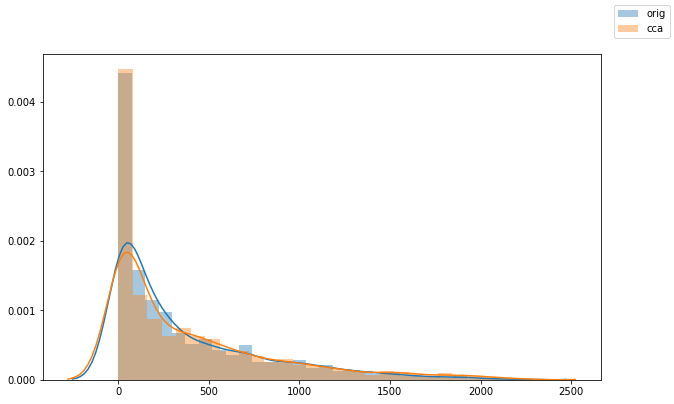

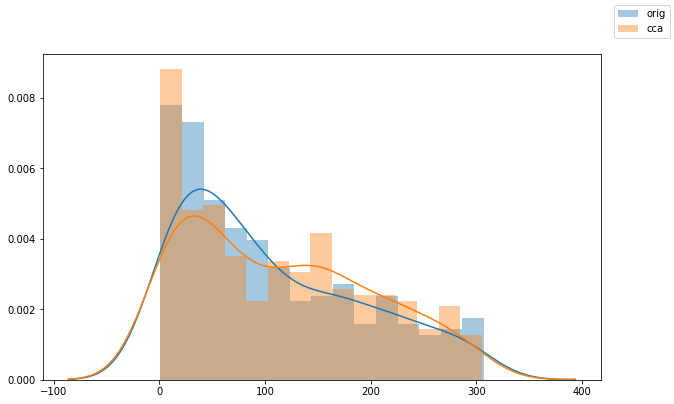

In [284]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.distplot(ranks_val_orig_all)
sns.distplot(ranks_val_cca_all)
fig.legend(labels=['orig','cca'])
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.distplot(ranks_val_orig_out, bins=15)
sns.distplot(ranks_val_cca_out, bins=15)
fig.legend(labels=['orig','cca'])
plt.show()

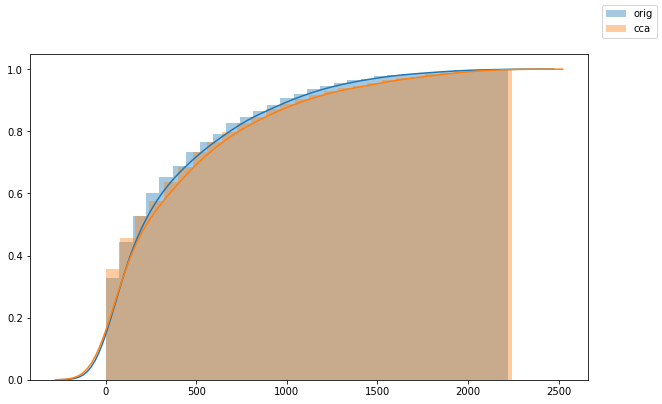

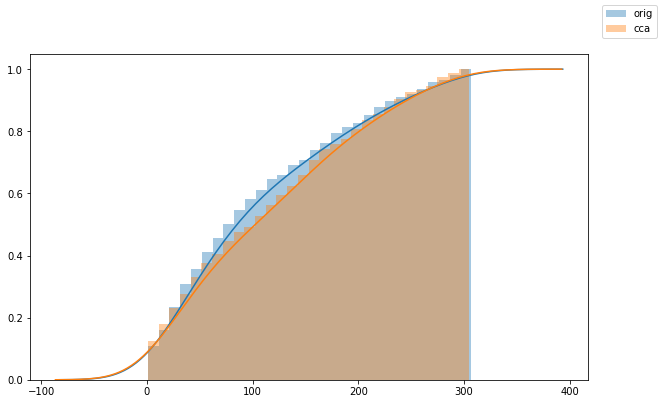

In [285]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.distplot(ranks_val_orig_all,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
sns.distplot(ranks_val_cca_all,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
fig.legend(labels=['orig','cca'])
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.distplot(ranks_val_orig_out,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
             bins=30)
sns.distplot(ranks_val_cca_out,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
             bins=30)
fig.legend(labels=['orig','cca'])
plt.show()

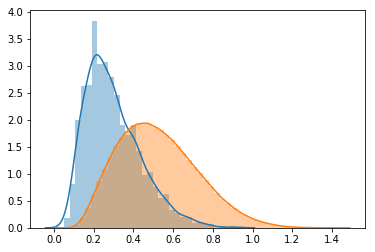

In [207]:
import seaborn as sns
sns.distplot(gex_chem_embed_dist.diagonal())
sns.distplot(gex_chem_embed_dist[np.triu_indices(2248, k=1)])